### Simulating a Maintenance Contract

- Notebook content :
- Load the libraries
- Loading the Data
- Transforming the column `order_purchase_timestamp` to the number of days since the last purchase
- Function to get the data for modelization
- Calculate the ARI score over time
- Define time intervals
- Calculate the ARI score for each time interval and visualize the results

#### Goal
To ensure that the clustering model remains stable and accurate over time by monitoring its performance and retraining it as needed. This involves:

1. **Finalizing an Optimized Clustering**: Ensure the clustering model is well-tuned and makes sense from a business perspective.
2. **Simulating Stability Over Time**: Track how stable the clusters are over different time periods.

#### Recommendations
1. **Use ARI (Adjusted Rand Index)**: Measure how similar the clusters are over time to decide when to retrain the model.
2. **Monitor Feature Distribution**: Analyze changes in the distribution of your features over time using graphical methods or statistical tests like the Kolmogorov-Smirnov test.

#### Vigilance Points
- Ensure consistency between the data used for initial training and the data for future predictions.


Date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
days_since_last_purchase statistics:
count    96096.000000
mean       289.061928
std        153.646258
min          0.000000
25%        165.000000
50%        270.000000
75%        399.000000
max        772.000000
Name: days_since_last_purchase, dtype: float64
Scores for interval 3 days:
 []
Scores for interval 7 days:
 []
Scores for interval 15 days:
 []
Scores for interval 30 days:
 [0.3908607992493531, 0.35143071925362757, 0.44311648446292656, 0.3747740871203489, 0.24748497076636009, 0.3314314267233097, 0.258885165742772, 0.34210630647977597, 0.22344643803204214, 0.24087091805219404, 0.3031917185594341, 0.3118355982144871, 0.21948934870109682, 0.21338438935943121, 0.23676423994208456, 0.2878460437680406, 0.2597922813273059, 0.25678029859060564, 0.23596876752945162, 0.146646629679412, 0.09615394920698171, 0.03113145567457397, 0.0]
Scores for interval 60 days:
 [0.11539809833722096, 0.04177015834547368, 0.1255964401591444, 0.064216

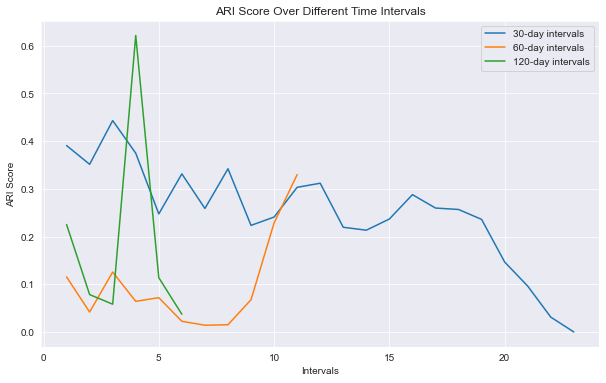

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from datetime import datetime

# Set environment variable to suppress the KMeans memory leak warning on Windows
os.environ["OMP_NUM_THREADS"] = "1"

# Load the data
db_path = os.path.join("..", "data")
df_final_kmeans_path = os.path.join(db_path, "df_final_kmeans_with_clusters.csv")
df_final_kmeans = pd.read_csv(df_final_kmeans_path)

# Define the date format
date_format = "%Y-%m-%d %H:%M:%S"  # Adjust this format according to your date format which is 'YYYY-MM-DD HH:MM:SS' in this case

# Identify the available date ranges
min_date_str = df_final_kmeans[
    "order_purchase_timestamp"
].min()  # Minimum date in the dataset as a string format for comparison
max_date_str = df_final_kmeans[
    "order_purchase_timestamp"
].max()  # Maximum date in the dataset as a string format for comparison
min_date = datetime.strptime(
    min_date_str, date_format
)  # Convert the minimum date to a datetime object, e.g. from '2016-09-04 21:15:19' to 2016-09-04 21:15:19
max_date = datetime.strptime(
    max_date_str, date_format
)  # Convert the maximum date to a datetime object, e.g. from '2018-09-03 09:06:57' to 2018-09-03 09:06:57

# Print the Date range which is: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
print(f"Date range: {min_date_str} to {max_date_str}")

# Transform the 'order_purchase_timestamp' column to the number of days since the max date in the dataset
df_final_kmeans["days_since_last_purchase"] = df_final_kmeans[
    "order_purchase_timestamp"
].apply(lambda x: (max_date - datetime.strptime(x, date_format)).days)

# Display unique values of 'days_since_last_purchase'
print("days_since_last_purchase statistics:")
print(df_final_kmeans["days_since_last_purchase"].describe())


# Function to get the data for modeling
def get_data_for_model(data, start_time, interval):
    end_time = start_time + interval
    return data[
        (data["days_since_last_purchase"] >= start_time)
        & (data["days_since_last_purchase"] < end_time)
    ]


# Define specific intervals
frequencies = [3, 7, 15, 30, 60, 120]  # 3, 7, 15, 30, 60, 120 days
scores_dict = {}

# Select only numeric columns for scaling and clustering
numeric_columns = df_final_kmeans.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove("days_since_last_purchase")

# Initial model on the data of D_0
initial_time = df_final_kmeans["days_since_last_purchase"].min()

for interval in frequencies:
    scores = []
    D0 = get_data_for_model(df_final_kmeans, initial_time, interval)

    if not D0.empty and len(D0) >= 4:  # Ensure at least 4 samples
        scaler = RobustScaler()
        D0_scaled = scaler.fit_transform(D0[numeric_columns])
        model_0 = KMeans(n_clusters=4).fit(D0_scaled)  # Use 4 clusters

        # Temporal loop to track the stability of the model
        for t in range(
            int(initial_time) + interval,
            int(df_final_kmeans["days_since_last_purchase"].max()),
            interval,
        ):
            Di = get_data_for_model(df_final_kmeans, t, interval)
            if Di.empty or len(Di) < 4:  # Ensure at least 4 samples
                continue

            Di_scaled = scaler.transform(Di[numeric_columns])
            model_i = KMeans(n_clusters=4).fit(Di_scaled)  # Use 4 clusters

            # Calculate the ARI
            labels_0 = model_0.predict(Di_scaled)
            labels_i = model_i.predict(Di_scaled)
            score = adjusted_rand_score(labels_0, labels_i)
            scores.append(score)

    scores_dict[interval] = scores

# Print ARI scores for each interval
for interval, scores in scores_dict.items():
    print(f"Scores for interval {interval} days:\n", scores)

# Visualize the results
plt.figure(figsize=(10, 6))
for interval, scores in scores_dict.items():
    if scores:
        print(
            f"Plotting scores for interval {interval} days: {scores}"
        )  # Print scores for verification
        plt.plot(range(1, len(scores) + 1), scores, label=f"{interval}-day intervals")
plt.xlabel("Intervals")
plt.ylabel("ARI Score")
plt.title("ARI Score Over Different Time Intervals")
plt.legend()
plt.show()

### Explanation of the ARI Score Over Time Graph

In this context, we're assessing the stability of a clustering model over time. The "intervals" on the x-axis represent the points in time when we check how well the model is performing.

When we say "30-day interval," it means that after every 30 days, we re-evaluate the model's clustering performance. For example:

- At the first interval (1 on the x-axis), we're checking how well the model clusters the data at the end of the first 30 days.
- At the fifth interval (5 on the x-axis), we check how well the model is clustering the data after 150 days (because 5 intervals × 30 days = 150 days).

Each point on the graph represents the Adjusted Rand Index (ARI) score at that specific time interval. The ARI score tells us how similar the clusters are compared to the previous evaluation. A high ARI score means that the clusters have remained stable and consistent over time, while a lower ARI score indicates that the model's clustering results are changing and becoming less consistent.

So, if you see a decline in the ARI score over several intervals, it suggests that the model's ability to maintain consistent clusters is decreasing as time progresses. This might signal the need for re-evaluating or updating the model to ensure it continues to perform well over time.

### Summary of ARI Scores and Stability

- **30-Day Interval**:
  - The ARI scores start high but show a sharp decline, indicating that cluster stability diminishes rapidly over this shorter time frame.
  - The range of ARI scores from 0.44 to 0.0 suggests that clusters become inconsistent as time progresses, necessitating frequent re-evaluations.

- **60-Day Interval**:
  - The ARI scores demonstrate some stability, although there are noticeable fluctuations.
  - Scores ranging from 0.35 to 0.01 reflect moderate consistency, with clusters holding together reasonably well over two-month intervals but showing signs of instability.

- **120-Day Interval**:
  - The ARI scores fluctuate significantly over longer periods, with an overall trend suggesting moderate stability.
  - Scores range from 0.22 to 0.03, indicating that clusters remain somewhat consistent over four months, but there is still variability that may require adjustments.

#### Graph Interpretation

The graph highlights the differences in cluster stability across three time intervals:

- **30-Day Interval**: A sharp decline in ARI scores suggests that cluster consistency is more likely to deteriorate over shorter periods.
- **60-Day Interval**: While the ARI scores show more stability than the 30-day interval, fluctuations indicate that clusters are stable yet still require periodic monitoring.
- **120-Day Interval**: The variability in ARI scores over this period suggests that clusters may remain consistent for longer but are more prone to instability, warranting occasional re-evaluation.

### Conclusion and Recommendations

1. **Cluster Stability**:
   - Clusters show a tendency to be less stable over shorter periods (30 days), with a noticeable decline in consistency.
   - Clusters over 60 and 120-day intervals exhibit moderate stability but also display fluctuations that may necessitate periodic re-evaluation.

2. **Model Maintenance**:
   - Re-evaluating and recalibrating clusters every two to four months is recommended to ensure stability without causing unnecessary adjustments.
   - A 30-day interval for re-evaluations may lead to instability due to frequent changes, making it less desirable for long-term planning.

3. **Continuous Monitoring**:
   - Monitoring ARI scores regularly at 60-day and 120-day intervals will help maintain cluster stability.
   - Significant drops in ARI scores, especially over longer intervals, should trigger a full re-evaluation of the clusters to maintain consistency.

### Example Maintenance Plan

- **Bi-Monthly Re-evaluation**: Re-evaluate clusters every two months using the 60-day interval to ensure stability.
- **Stability Reports**: Generate stability reports at each re-evaluation to track performance and make necessary adjustments.
- **Adjustment Based on ARI Scores**: Conduct a full re-evaluation if ARI scores for the 120-day interval decline significantly, adjusting clusters accordingly.

### Final Conclusion

Re-evaluating and recalibrating clusters every **three months** is recommended, striking a balance between stability and avoiding unnecessary adjustments. This interval aligns with the suggested two to four-month range and supports sustained cluster consistency.